# Semantic Search Without Pre-training

## Set Up

In [1]:
!pip install -q sentence_transformers

In [46]:
 !pip3 install --upgrade pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [323]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

## Import Data

In [361]:
import pandas as pd
import numpy as np
import pickle
import math

running_on_test = True
handcrafted = False

In [362]:
if IN_COLAB:
    data = pd.read_csv('/content/gdrive/Shareddrives/Rice Datathon 2023 - Team VAMB/Bill.com/users_w_ocr.csv').iloc[:,1:].rename(columns={'Texts': 'OCR_text'})
else:
    data = pd.read_csv('/kaggle/input/billcom/users_w_ocr.csv').iloc[:,1:].rename(columns={'Texts': 'OCR_text'})
    test = pd.read_csv('/kaggle/input/billcom/test_transactions.csv')
    ocr_data = pd.read_csv('/kaggle/input/billcom/ocr_ids_text.csv').iloc[:,1:].rename(columns={'ID': 'documentid', 'Texts': 'OCR_text'})
    
data['user_input'] = data['vendor_name'] + ' ' + data['vendor_address']
data = data.drop(columns=['vendor_name', 'vendor_address'])

test['user_input'] = test['vendor_name'] + ' ' + test['vendor_address']

data = data[['documentid', 'paymentid', 'amount', 'date', 'user_input', 'OCR_text']]

user_max_len = len(max(data['user_input'], key=len))

In [363]:
data.head()

,documentid,paymentid,amount,date,user_input,OCR_text
0,00d0624439175,00p0535380313,72.90,2916-4-17,MR. D.I.Y. (KUCHZAI) SDNBHD LOT 1851-A & 1851-...,MR. D.I.Y. (KUCHAI) SDN BHD LOT 1851-A & 1851-...
1,00d0654270874,00p0432205035,43.90,2016-6-7,FOUR QUARTERS SDN BHD NO.28G JLN SS21/35 DAMAN...,A PIE THING FOUR QUARTERS SDN BHD (1079369-P) ...
2,00d0403711886,00p0174820163,32.23,2018-10-1,"SYARIKAT PERNIAGAAN GIJ KEE NO 290, JALAN AIR ...",SYARIKAT PERNIAGAAN GIN KEE (81109-A) NO 290 J...
3,00d0956164753,00p0943784617,503.10,2018-3-23,"TIMELESS KITCHENETE SDN BHD LLT 50, FLOOR T2,S...",Morganfields* % Home of Suicky Bones * Timel...
4,00d0667839698,00p0762437501,1110.00,2016-2-28,"SIN THEY & COMPANY NO.54, BATU 5,JALAN IPOH, K...",SIMPLIFIED TAX INVOICE SIN THYE & COMPANY REG...


Import extracted ocr features:

In [364]:
ocr_ex = pd.read_csv('/kaggle/input/billcom/dataframe.csv', delimiter='\t').iloc[:,1:].rename(columns={'doc_id': 'documentid', 'payment_id':'paymentid'})
ocr_ex['OCR_text'] = ocr_ex['S-COMPANY'] + ' ' + ocr_ex['S-ADDRESS']

# Fix NaNs
for i, (txt,pid) in enumerate(zip(ocr_ex['OCR_text'].copy(), ocr_ex['paymentid'])):
    if txt!=txt:
        if len(data[data['paymentid']==pid]['OCR_text'])>=1:
            ocr_ex['OCR_text'].iloc[i] = data[data['paymentid']==pid]['OCR_text'].values[0][:user_max_len]
    else:
        ocr_txts.append(txt)

In [365]:
if running_on_test:
    users = test[['documentid', 'user_input']].copy()
else:
    users = data[['documentid', 'user_input']].copy()
if handcrafted:
    ocr = ocr_ex[['documentid', 'OCR_text']].copy()
else:
    ocr = ocr_data[['documentid', 'OCR_text']].copy()

Split into training, val, test:

In [366]:
def split(df):

    df_test = df.iloc[math.floor(len(df)*0.9):]
    df_val = df.iloc[math.floor(len(df)*0.8):math.floor(len(df)*0.9)]
    df_train = df.iloc[:math.floor(len(df)*0.8)]

    return df_train, df_val, df_test

In [367]:
if not running_on_test:
    users_train, users_val, users_test = split(users)
    users = users_train
#ocr_train, ocr_val, ocr_test = split(ocr)

In [368]:
if not running_on_test:
    print('SET SIZES:')
    print(f'Training: {users_train.shape}')
    print(f'Val: {users_val.shape}')
    print(f'Test: {users_test.shape}')
else:
    print(f'TEST SET SIZE: {test.shape}')

TEST SET SIZE: (126, 7)


## Build Model and Embed Sentences

In [369]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
import torch

In [370]:
if not running_on_test:
    user_text_input = users_train['user_input'].tolist()
    user_max_len = len(max(users_train['user_input'], key=len))
else:
    user_text_input = test['user_input'].tolist()
    user_max_len = len(max(data['user_input'], key=len))

ocr_text_input = ocr['OCR_text'].tolist()
if not handcrafted:
    ocr_text_input = [txt[:user_max_len] for txt in ocr_text_input]

In [372]:
def get_embeddings(model_name, user, ocr):

    if torch.cuda.is_available():
        model = SentenceTransformer(model_name, device='cuda')
    else:
        model = SentenceTransformer(model_name)
    user_embeddings = model.encode(user, convert_to_tensor=True)
    ocr_embeddings = model.encode(ocr, convert_to_tensor=True)

    return (user_embeddings, ocr_embeddings)

In [373]:
#models = ['all-mpnet-base-v2', 'multi-qa-mpnet-base-dot-v1', 'all-distilroberta-v1', 'all-MiniLM-L12-v2', 'multi-qa-distilbert-cos-v1', 'all-MiniLM-L6-v2', \
#          'multi-qa-MiniLM-L6-cos-v1', 'paraphrase-multilingual-mpnet-base-v2','paraphrase-albert-small-v2', 'paraphrase-multilingual-MiniLM-L12-v2', 'paraphrase-MiniLM-L3-v2',\
#          'distiluse-base-multilingual-cased-v1', 'distiluse-base-multilingual-cased-v2', 'msmarco-MiniLM-L6-cos-v5']
models = ['multi-qa-mpnet-base-dot-v1', 'distiluse-base-multilingual-cased-v1']

embeddings = [get_embeddings(name, user_text_input, ocr_text_input) for name in models]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

## Calculate Similarities

For each user input, loop through the OCR-text and find the most similar text. Store the payment_ID of the row from the OCR-text and from the user-input.

In [374]:
cosine_scores = [util.cos_sim(user_embedding, ocr_embedding).cpu().numpy() for user_embedding, ocr_embedding in embeddings]
dot_scores = [util.dot_score(user_embedding, ocr_embedding).cpu().numpy() for user_embedding, ocr_embedding in embeddings]

In [375]:
def get_top_k(k, scores):

    matches = []
    sim, idxes = torch.topk(torch.tensor(scores), k=k)
    matches = [(user_did, ocr['documentid'].iloc[idxes[i]].values) for i, user_did in enumerate(users['documentid'])]

    return matches

def get_perf(matches):
    matches = pd.DataFrame.from_records(matches, columns=['user_did', 'ocr_did'])
    matches['match'] = [1 if matches['user_did'].iloc[i] in matches['ocr_did'].iloc[i] else 0 for i in range(len(matches))]
    num_correct = matches['match'].sum()
    return num_correct

In [376]:
cos_perf = []
match_lens = list(range(1,51))
for i, model in enumerate(models):

    matches = []
    for k in match_lens:
        matches.append(get_top_k(k, cosine_scores[i].copy()))

    p = [get_perf(m)/users_train.shape[0] for m in matches]
    cos_perf.append(p)


In [377]:
dot_perf = []
for i, model in enumerate(models):

    matches = []
    for k in match_lens:
        matches.append(get_top_k(k, dot_scores[i].copy()))

    p = [get_perf(m)/users_train.shape[0] for m in matches]
    dot_perf.append(p)

## Performance

In [378]:
import matplotlib.pyplot as plt

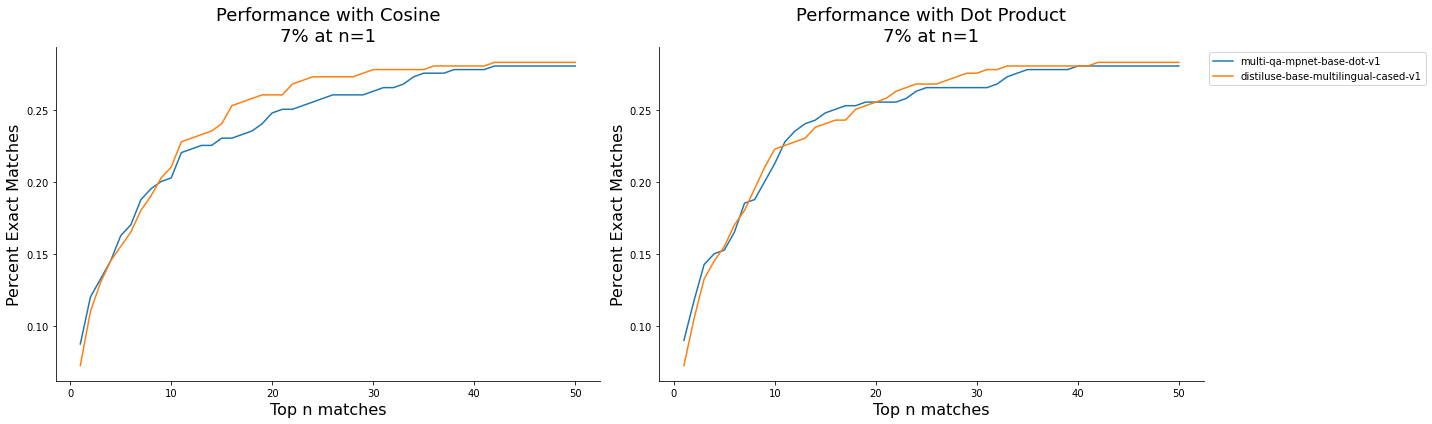

In [379]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax = ax.ravel()

for model, p in zip(models,cos_perf):
    ax[0].plot(match_lens, p, label=model)

for model, p in zip(models,dot_perf):
    ax[1].plot(match_lens, p, label=model)

ax[0].set_title(f'Performance with Cosine\n{cos_perf[1][0]*100:.0f}% at n=1', fontsize=18)
ax[1].set_title(f'Performance with Dot Product\n{dot_perf[1][0]*100:.0f}% at n=1', fontsize=18)

for axs in ax:
    axs.set_ylabel('Percent Exact Matches', fontsize=16)
    axs.set_xlabel('Top n matches', fontsize=16)
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)

ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout();

# Retrieve and Rerank

## Import Models

In [380]:
from sentence_transformers import CrossEncoder

In [381]:
bi_encoder = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cuda')
bi_encoder.max_seq_length = 256
top_k = 20

In [382]:
cross_encoder_models = ['cross-encoder/ms-marco-MiniLM-L-2-v2', 'cross-encoder/ms-marco-TinyBERT-L-2-v2', 'cross-encoder/ms-marco-MiniLM-L-12-v2', 'cross-encoder/ms-marco-TinyBERT-L-6', 'cross-encoder/ms-marco-electra-base']

## Encode with Bi-Encoder to find potentially relevent receipts

In [383]:
user_embedding = bi_encoder.encode(user_text_input, convert_to_tensor=True).cuda()
receipt_embeddings = bi_encoder.encode(ocr_text_input, convert_to_tensor=True).cuda()

hits = util.semantic_search(user_embedding, receipt_embeddings, top_k=top_k)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [384]:
all_reranked_hits = []
for model in cross_encoder_models:

    if torch.cuda.is_available():
        cross_encoder = CrossEncoder(model, device='cuda')
    else:
        cross_encoder = CrossEncoder(model)

    all_cross_scores = []
    reranked_hits = []
    for user_query, hit in zip(user_text_input, hits):

        hit_dict = pd.DataFrame.from_records(hit)
        likely_receipt = [[user_query, ocr_text_input[idx]] for idx in hit_dict['corpus_id'].values]
        cross_scores = cross_encoder.predict(likely_receipt, batch_size=200, show_progress_bar=False)
        all_cross_scores.append(cross_scores)

        for idx in range(len(cross_scores)):
            hit[idx]['cross-score'] = cross_scores[idx]

        hit = sorted(hit, key=lambda x: x['cross-score'], reverse=True)

        reranked_hits.append(hit)
    
    all_reranked_hits.append(reranked_hits)

## Plot Performance

In [387]:
def get_top_n(n, hits):

    matches = []

    for i, (query_hit, user_pid) in enumerate(zip(hits, users['documentid'])):
        query_hit = pd.DataFrame.from_records(query_hit[:n])
        matches.append((user_pid, ocr['documentid'].iloc[query_hit['corpus_id'].values].values))

    return matches

In [388]:
top_n = list(range(1,10))
all_matches = [[get_top_n(n, rrh) for n in top_n] for rrh in all_reranked_hits]
perf = [[get_perf(m)/users_train.shape[0] for m in matches] for matches in all_matches]

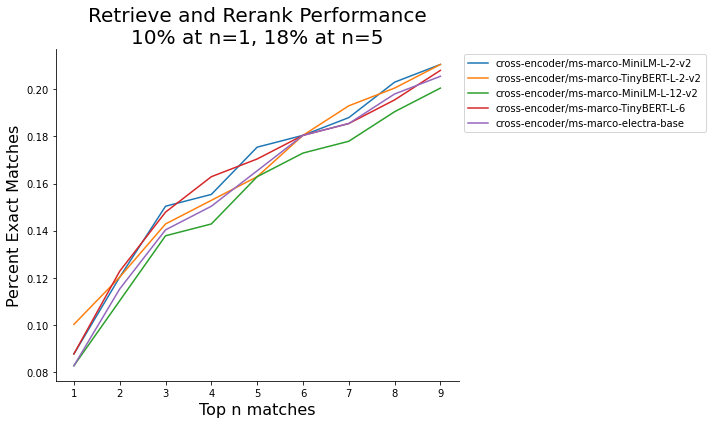

In [389]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

for name, p in zip(cross_encoder_models, perf):
    ax.plot(top_n, p, label=name)

ax.set_title(f'Retrieve and Rerank Performance\n{np.max(np.array(perf)[:,0])*100:.0f}% at n=1, {np.max(np.array(perf)[:,4])*100:.0f}% at n=5', fontsize=20)

ax.set_ylabel('Percent Exact Matches', fontsize=16)
ax.set_xlabel('Top n matches', fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.tight_layout();